In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import optuna
import random
import itertools
from itertools import permutations
torch.set_printoptions(edgeitems=2, linewidth=75)

In [8]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [9]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

# df1とdf2のリスト
dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors


In [10]:
k1 = torch.tensor(-8.523792266845703)
k2 = torch.tensor(1.097792625427246)
k3 = torch.tensor(-1.8107989774307498e-07)
k4 = torch.tensor(-8.808075904846191)
k5 = torch.tensor(0.6218917369842529)
k6 = torch.tensor(-0.6827405691146851)
t1 = torch.tensor(5.5464264733018354e-05)
p1 = torch.tensor(90.0)
t2 = torch.tensor(90.0)
p2 = torch.tensor(64.0386962890625)

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

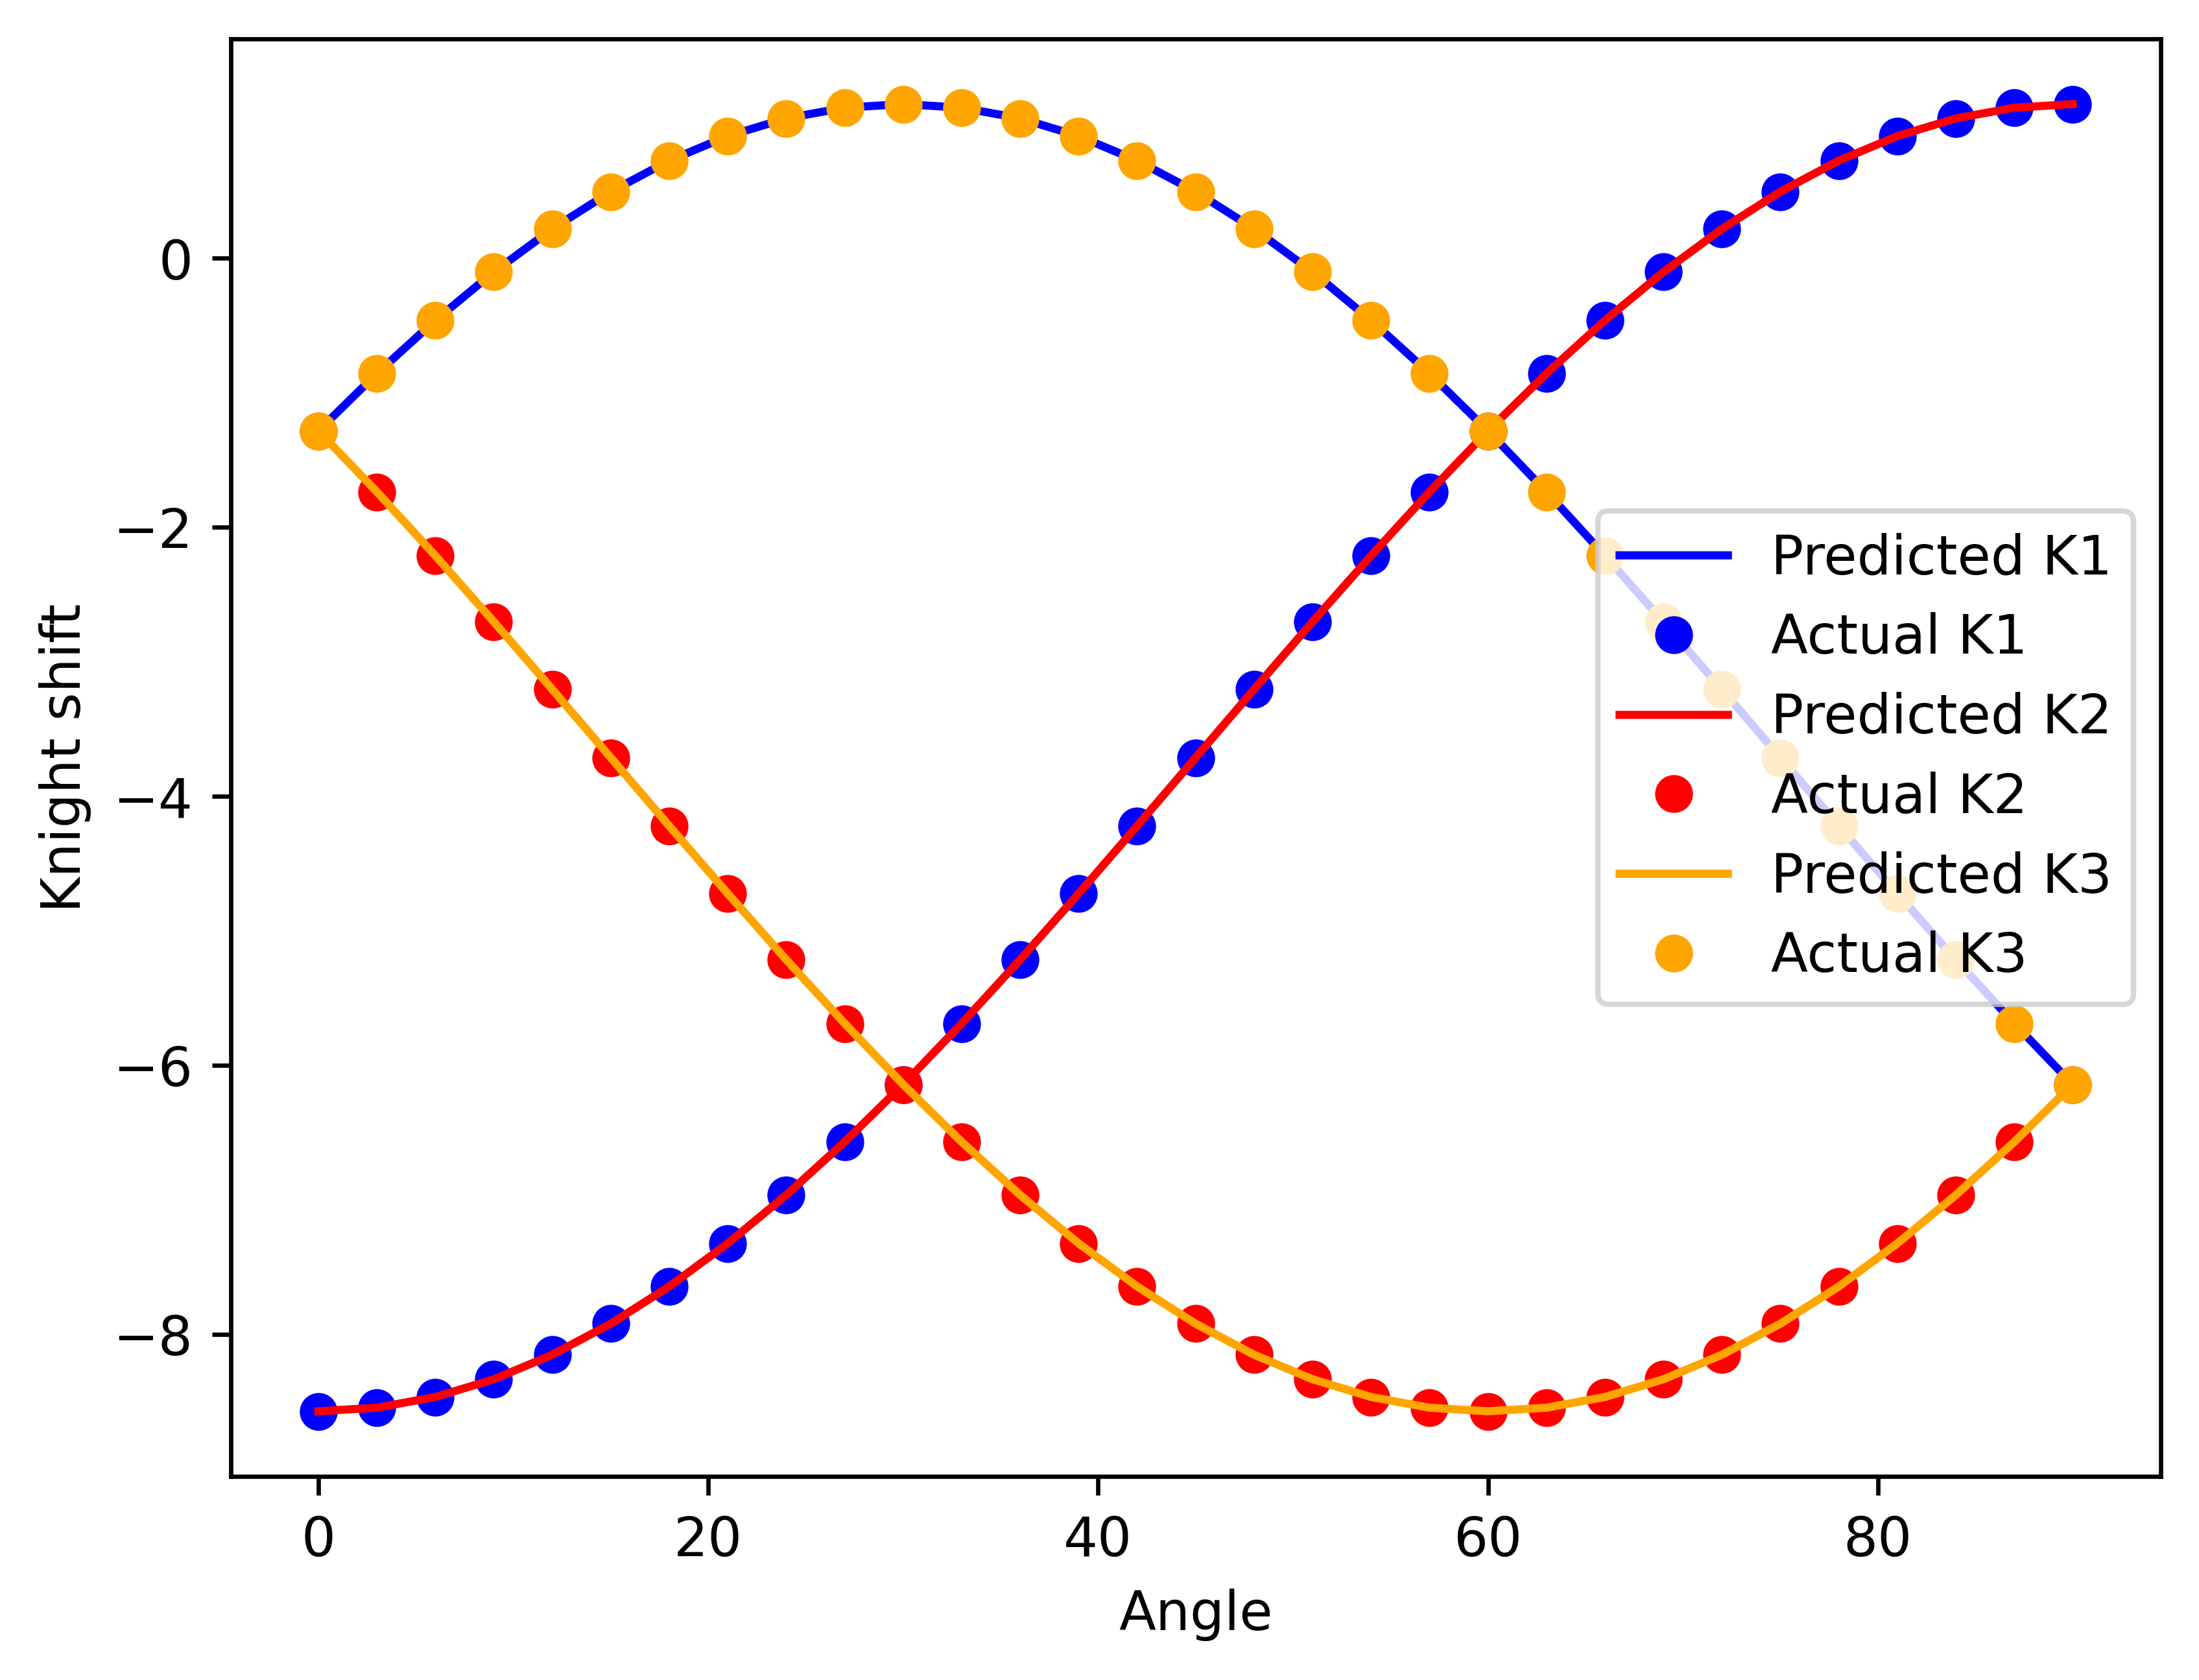

In [11]:
# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1", color = "blue")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2", color = "red")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3", color = "orange")

# plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
# plt.plot(x4.detach().numpy(), y4.numpy(), 'h', label="Actual K1v", color = "green")

# plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
# plt.plot(x5.detach().numpy(), y5.numpy(), 'h', label="Actual K2v", color = "purple")

# plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
# plt.plot(x6.detach().numpy(), y6.numpy(), 'h', label="Actual K3v", color = "black")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

In [12]:
import itertools

# Use these parameters in your model for each input
outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

# 全てのインデックスの組み合わせを生成
shift1_permutations = list(itertools.permutations([0, 1, 2]))  # shift1の6通り
shift2_permutations = list(itertools.permutations([0, 1, 2]))  # shift2の6通り

# shift1とshift2の全組み合わせをループ
for idx, (perm1, perm2) in enumerate(itertools.product(shift1_permutations, shift2_permutations)):
    print(f"\nバージョン {idx + 1}:")

    # shift1とshift2のインデックスに基づいてy_p1〜y_p6を設定
    y_p1, y_p2, y_p3 = outputs[0]['shift1'][perm1[0]], outputs[1]['shift1'][perm1[1]], outputs[2]['shift1'][perm1[2]]
    y_p4, y_p5, y_p6 = outputs[3]['shift2'][perm2[0]], outputs[4]['shift2'][perm2[1]], outputs[5]['shift2'][perm2[2]]

    print(f"y_p1: {y_p1}, y_p2: {y_p2}, y_p3: {y_p3}")
    print(f"y_p4: {y_p4}, y_p5: {y_p5}, y_p6: {y_p6}")


バージョン 1:
y_p1: tensor([-1.2835, -0.8570, -0.4617, -0.1021,  0.2180,  0.4950,  0.7259,
         0.9082,  1.0398,  1.1194,  1.1460,  1.1194,  1.0398,  0.9082,
         0.7259,  0.4950,  0.2180, -0.1021, -0.4617, -0.8570, -1.2835,
        -1.7367, -2.2115, -2.7028, -3.2051, -3.7130, -4.2209, -4.7232,
        -5.2145, -5.6893, -6.1425], grad_fn=<SelectBackward0>), y_p2: tensor([-8.5720, -8.5454, -8.4658, -8.3342, -8.1519, -7.9210, -7.6440,
        -7.3239, -6.9643, -6.5690, -6.1425, -5.6893, -5.2145, -4.7232,
        -4.2209, -3.7130, -3.2051, -2.7028, -2.2115, -1.7367, -1.2835,
        -0.8570, -0.4617, -0.1021,  0.2180,  0.4950,  0.7259,  0.9082,
         1.0398,  1.1194,  1.1460], grad_fn=<SelectBackward0>), y_p3: tensor([-1.2835, -1.7367, -2.2115, -2.7028, -3.2051, -3.7130, -4.2209,
        -4.7232, -5.2145, -5.6893, -6.1425, -6.5690, -6.9643, -7.3239,
        -7.6440, -7.9210, -8.1519, -8.3342, -8.4658, -8.5454, -8.5720,
        -8.5454, -8.4658, -8.3342, -8.1519, -7.9210, -7.6440, -